In [1]:
# Note: Cell is tagged to not show up in the mkdocs build
%load_ext autoreload
%autoreload 2

<div class="admonition abstract highlight">
    <p class="admonition-title">In short</p>
    <p>This tutorial shows how we can create more complicated datasets by leveraging the dataset factory in Polaris.</p>
</div>

<div class="admonition abstract example">
    <p class="admonition-title">This feature is still very new</p>
    <p>The features we will show in this tutorial are still experimental. We would love to learn from the community how we can make it easier to create datasets.</p>
</div>

In [2]:
import platformdirs
import datamol as dm

## Dataset Factory
Datasets in Polaris are expected to be saved in a very specific format. This format has been carefully designed to be as universal and performant as possible. Nevertheless, we expect very few datasets to be readily available in this format. We therefore provide the `DatasetFactory` as a way to more easily convert datasets to the Polaris specific format.

Let's assume we have a dataset in the SDF format. 

In [3]:
SAVE_DIR = dm.fs.join(platformdirs.user_cache_dir(appname="polaris-tutorials"), "003")

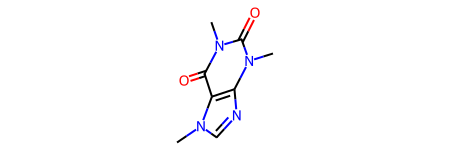

In [4]:
# Let's generate a toy dataset with a single molecule
smiles = "Cn1cnc2c1c(=O)n(C)c(=O)n2C"
mol = dm.to_mol(smiles)

# We will generate 3D conformers for this molecule with some conformers
mol = dm.conformers.generate(mol, align_conformers=True)

# Let's also set a molecular property
mol.SetProp("my_property", "my_value")

mol

In [5]:
path = dm.fs.join(SAVE_DIR, "caffeine.sdf")
dm.to_sdf(mol, path)

This being a toy example, it is a very small dataset. However, for many real-world datasets SDF files can quickly get large, at which point it is no longer efficient to store everything directly in the Pandas DataFrame. This is why Polaris supports [pointer columns](./dataset_zarr.html) to store large data outside of the DataFrame in a Zarr archive. But... How to convert from SDF to Zarr? 

There are a lot of considerations here: 
- You want read and write operations to be quick.
- You want to reduce the storage requirements.
- You want the conversion to be lossless.

Chances are you've no in-depth understanding of how Zarr works, making it a big investment to convert your SDF dataset to Zarr.

`DatasetFactory` to the rescue!

In [6]:
from polaris.dataset import DatasetFactory
from polaris.dataset.converters import SDFConverter

# Create a new factory object
save_dst = dm.fs.join(SAVE_DIR, "data.zarr")
factory = DatasetFactory(zarr_root_path=save_dst)

# Register a converter for the SDF file format
factory.register_converter("sdf", SDFConverter())

# Process your SDF file
factory.add_from_file(path)

# Build the dataset
dataset = factory.build()

That's all! Let's take a closer look at what this has actually done.

In [7]:
dataset.annotations

{'smiles': ColumnAnnotation(is_pointer=False, modality=<Modality.MOLECULE: 'molecule'>, description=None, user_attributes={}, dtype=dtype('O')),
 'my_property': ColumnAnnotation(is_pointer=False, modality=<Modality.UNKNOWN: 'unknown'>, description=None, user_attributes={}, dtype=dtype('O')),
 'molecule': ColumnAnnotation(is_pointer=True, modality=<Modality.MOLECULE_3D: 'molecule_3D'>, description=None, user_attributes={}, dtype=dtype('O'))}

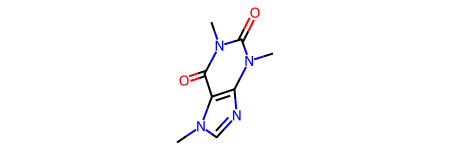

In [8]:
dataset.get_data(row=0, col="molecule")

We can see that Polaris has: 
- Saved the molecule in an external Zarr archive and set the column annotations accordingly.
- Has extracted the molecule-level properties as additional columns.
- Has added an additional column with the SMILES.
- Effortlessly saves and loads the molecule object from the Zarr.

## Factory Design Pattern
If you've been dilligently going through the tutorials, you might remember that there is a function that seems to be doing something similar. And you would be right!

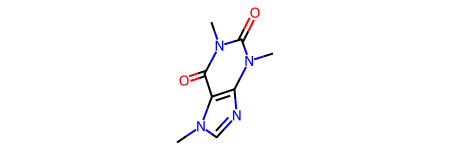

In [9]:
from polaris.dataset import create_dataset_from_file

dataset = create_dataset_from_file(path, save_dst)
dataset.get_data(row=0, col="molecule")

The `DatasetFactory` is based on the factory design pattern. That way, you can easily create and add your own file converters. However, the defaults are set to be a good option for most people. 

Let's consider two cases that show the power of the `DatasetFactory` design. 

### Configuring the converter
Let's assume we do not want to extract the properties as separate columns, but rather keep them in the RDKit object. We cannot do this with the default converter, but we can configure its behavior to achieve this. 

In [10]:
save_dst = dm.fs.join(SAVE_DIR, "data2.zarr")
factory.reset(save_dst)

# Configure the converter
converter = SDFConverter(mol_prop_as_cols=False)

# Overwrite the converter for SDF files
factory.register_converter("sdf", converter)

# Process the SDF file again
factory.add_from_file(path)

# Build the dataset
dataset = factory.build()

2024-03-26 13:16:43.897 | INFO     | polaris.dataset._factory:register_converter:112 - You are overwriting the converter for the sdf extension.


And voila! The property is saved to the Zarr instead of to a separate column. 

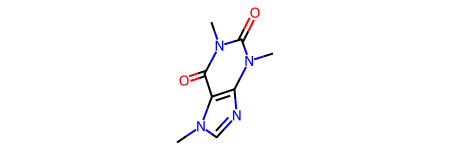

In [11]:
dataset.get_data(row=0, col="molecule")

In [12]:
dataset.table

,smiles,molecule
0,CN1C=NC2=C1C(=O)N(C)C(=O)N2C,molecule#0


### Merging data from different sources

Another case is when you want to merge data from multiple sources. Maybe you have two different SDF files.

In [13]:
save_dst = dm.fs.join(SAVE_DIR, "data3.zarr")
factory.reset(save_dst)

# Let's pretend these are two different SDF files
factory.register_converter("sdf", SDFConverter(mol_column="molecule1", smiles_column=None))
factory.add_from_file(path)

# We change the configuration between files
factory.register_converter("sdf", SDFConverter(mol_column="molecule2", mol_prop_as_cols=False))
factory.add_from_file(path)

dataset = factory.build()

2024-03-26 13:16:43.938 | INFO     | polaris.dataset._factory:register_converter:112 - You are overwriting the converter for the sdf extension.
2024-03-26 13:16:43.945 | INFO     | polaris.dataset._factory:register_converter:112 - You are overwriting the converter for the sdf extension.


In [14]:
dataset.table

,my_property,molecule1,smiles,molecule2
0,my_value,molecule1#0,CN1C=NC2=C1C(=O)N(C)C(=O)N2C,molecule2#0


The End. 